# TabNet in Pytorch - New Solution to Tabular ML problems

### Tabnet has basic GLU (Gated Linear Unit) Activuation
### with shared layers 

## Parameter to Tune at https://github.com/dreamquark-ai/tabnet

It outperfomrs in many tree-based boosting algorithms !!

### Architecture

![a](https://image.slidesharecdn.com/tabnetpresentation-200606103121/95/tabnet-presentation-7-638.jpg?cb=1591439795)

![Arc2](https://image.slidesharecdn.com/tabnetpresentation-200606103121/95/tabnet-presentation-8-638.jpg?cb=1591439795)

Advantage:
1. We can stack as much as we want (More steps, bigger the model)
2. All steps contribute equally to the final layer (depending on the problems like regression or classification)

![Explanability](https://image.slidesharecdn.com/tabnetpresentation-200606103121/95/tabnet-presentation-11-638.jpg?cb=1591439795)

Has a robust explanability, and it's sk-learn compatible!

## let's dive into examples!

# Example

## 1. Classification

In [63]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

import os
import math
import random
import pathlib
import json
import wget
from pathlib import Path
import shutil
import gzip

import matplotlib.pyplot as plt
%matplotlib inline

print('Pytorch Version:', torch.__version__)

Pytorch Version: 1.5.0


### (1) Load Data

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [6]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

100% [........................................................................] 11240707 / 11240707

### (2) Train/Test Split

In [8]:
target = "Covertype"

categorical = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

integer = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    integer + categorical + [target])

In [9]:
train = pd.read_csv(out, header=None, names=feature_columns)
train.head()

n_total = len(train)
print(n_total)

# Train, val and test split follows
train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)

train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

581012


### (3) Pre-Processing

In [10]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

### (4) Define categorical features for categorical embeddings

In [11]:
unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

### (5) Create a Model

In [12]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    lr=0.02,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

Device used : cuda


### (6) Train a Model

In [13]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [14]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [15]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256
)

Will train until validation stopping metric hasn't improved in 100 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.56079 |  0.22032 |   32.7      
| 2     | 0.66891 |  0.24418 |   61.4      
| 3     | 0.69981 |  0.15226 |   96.2      
| 4     | 0.71060 |  0.15770 |   131.4     
| 5     | 0.71834 |  0.16619 |   166.8     
| 6     | 0.72683 |  0.20677 |   203.1     
| 7     | 0.73037 |  0.18427 |   239.1     
| 8     | 0.73657 |  0.21702 |   280.2     
| 9     | 0.73895 |  0.25973 |   317.0     
| 10    | 0.74255 |  0.30849 |   352.5     
| 11    | 0.74675 |  0.38309 |   390.7     
| 12    | 0.74869 |  0.40913 |   428.0     
| 13    | 0.75236 |  0.50597 |   462.0     
| 14    | 0.75527 |  0.55599 |   496.0     
| 15    | 0.75886 |  0.58694 |   530.7     
| 16    | 0.76262 |  0.61613 |   568.2     
| 17    | 0.76595 |  0.67300 |   606.0     
| 18    | 0.77195 |  0.70184 |   643.8     
| 19    | 0.77594 |  0.72445 |   681.7     
| 2

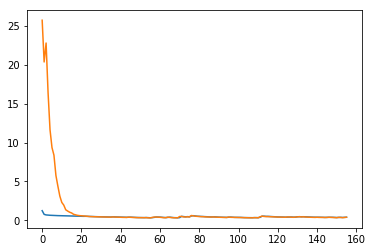

In [16]:
# plot losses
plt.plot(clf.history['train']['loss'])
plt.plot(clf.history['valid']['loss'])

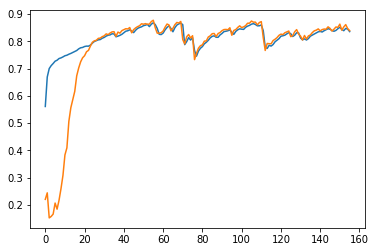

In [17]:
# plot accuracies
plt.plot([-x for x in clf.history['train']['metric']])
plt.plot([-x for x in clf.history['valid']['metric']])

### (7) Evaluate and Prediction

In [19]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR forest-cover-type : -0.8769435318871541
FINAL TEST SCORE FOR forest-cover-type : 0.877946352503808


In [20]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

### (8) ML Explanation

##### Global explainability : feat importance summing to 1

In [23]:
clf.feature_importances_

array([2.06985060e-01, 2.05323116e-02, 8.68474068e-04, 7.32807603e-02,
       1.06426423e-02, 7.81555935e-02, 1.22019225e-02, 1.87041664e-02,
       1.67281014e-02, 3.83164078e-03, 7.75130077e-02, 2.43340951e-03,
       1.09689558e-02, 5.94868120e-04, 4.12367991e-03, 6.77477575e-03,
       8.66506355e-03, 1.76662957e-02, 8.33596323e-03, 1.35711919e-02,
       6.68019313e-03, 2.82436978e-03, 1.44143876e-02, 2.10648958e-02,
       9.58632393e-03, 5.10320237e-02, 1.63746540e-03, 2.73632031e-03,
       2.65570922e-03, 2.12177448e-02, 2.18405046e-02, 3.22798531e-04,
       2.70298286e-03, 3.81003808e-03, 6.26933684e-04, 1.54110747e-02,
       7.34738564e-02, 1.56653783e-02, 1.09570278e-02, 5.22872951e-06,
       8.67283266e-03, 8.37724958e-03, 2.26903581e-02, 1.50456830e-02,
       5.19529021e-03, 2.67514849e-02, 1.43090885e-02, 2.96755618e-03,
       2.34175126e-04, 1.35612338e-03, 2.87748463e-03, 1.10573521e-02,
       2.11722111e-04, 9.01045860e-03])

##### Local explainability and masks

In [25]:
explain_matrix, masks = clf.explain(X_test)

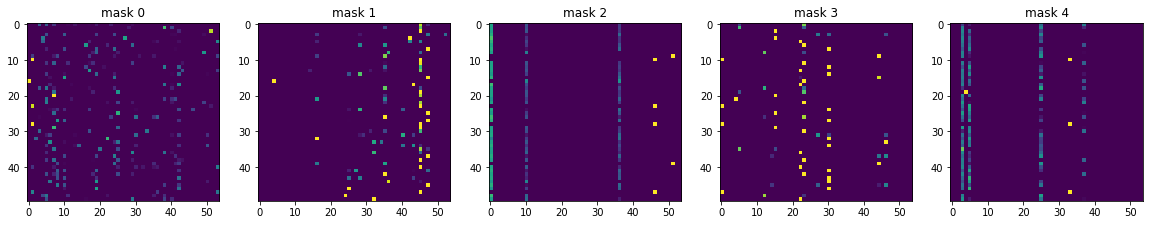

In [26]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

### Implementation in XGBoost

In [28]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [29]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

[0]	validation_0-merror:0.220102
Will train until validation_0-merror hasn't improved in 40 rounds.
[10]	validation_0-merror:0.195292
[20]	validation_0-merror:0.184288
[30]	validation_0-merror:0.17753
[40]	validation_0-merror:0.170727
[50]	validation_0-merror:0.162376
[60]	validation_0-merror:0.15656
[70]	validation_0-merror:0.151268
[80]	validation_0-merror:0.14644
[90]	validation_0-merror:0.141348
[100]	validation_0-merror:0.136733
[110]	validation_0-merror:0.132015
[120]	validation_0-merror:0.127006
[130]	validation_0-merror:0.123005
[140]	validation_0-merror:0.119055
[150]	validation_0-merror:0.11464
[160]	validation_0-merror:0.110348
[170]	validation_0-merror:0.107198
[180]	validation_0-merror:0.103397
[190]	validation_0-merror:0.099834
[200]	validation_0-merror:0.097485
[210]	validation_0-merror:0.093922
[220]	validation_0-merror:0.091353
[230]	validation_0-merror:0.089004
[240]	validation_0-merror:0.086467
[250]	validation_0-merror:0.084066
[260]	validation_0-merror:0.081427
[27

XGBClassifier(max_depth=8, n_estimators=1000, n_jobs=-1,
              objective='multi:softprob', subsample=0.7, verbosity=0)

In [30]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)

0.9596481150403067
0.9604399197955302


## 2. Regression

### (1) Load Data

In [52]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [53]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


### (2) Train/Test Split

In [54]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [55]:
train_indices

Int64Index([    0,     1,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            32548, 32549, 32550, 32551, 32553, 32554, 32555, 32556, 32557,
            32559],
           dtype='int64', length=26094)

### (3) Pre-Processing

Label encode categorical features and fill empty cells.

In [56]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
 Bachelors 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 United-States 42
 <=50K 2
Set 3


### (4) Define categorical features for categorical embeddings

In [57]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

### (5) Create a Model

In [58]:
clf = TabNetRegressor(cat_dims=cat_dims, 
                      cat_emb_dim=cat_emb_dim, 
                      cat_idxs=cat_idxs)

Device used : cuda


### (6) Train a Model

In [59]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

In [60]:
max_epochs = 1000 if not os.getenv("CI", False) else 20

In [61]:
clf.fit(
    X_train=X_train, y_train=y_train,
    X_valid=X_valid, y_valid=y_valid,
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

Will train until validation stopping metric hasn't improved in 50 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | -0.17033 |  -0.27162 |   5.8       
| 2     | -0.13373 |  -0.18774 |   11.4      
| 3     | -0.12592 |  -0.16804 |   17.5      
| 4     | -0.12041 |  -0.13407 |   23.4      
| 5     | -0.11810 |  -0.12819 |   29.7      
| 6     | -0.11661 |  -0.13072 |   36.0      
| 7     | -0.11288 |  -0.12724 |   42.6      
| 8     | -0.11267 |  -0.11723 |   48.7      
| 9     | -0.11055 |  -0.11717 |   54.6      
| 10    | -0.10884 |  -0.11294 |   60.4      
| 11    | -0.10612 |  -0.10995 |   66.9      
| 12    | -0.10412 |  -0.11029 |   72.7      
| 13    | -0.10403 |  -0.10978 |   78.5      
| 14    | -0.10333 |  -0.11039 |   84.4      
| 15    | -0.10214 |  -0.10864 |   90.2      
| 16    | -0.10224 |  -0.10830 |   96.2      
| 17    | -0.10264 |  -0.11234 |   102.2     
| 18    | -0.10092 |  -0.10992 |   108.0     
| 19    | -0

### (7) Evaluate and Prediction

In [64]:
preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_score}")

BEST VALID SCORE FOR census-income : 0.10466502606868744
FINAL TEST SCORE FOR census-income : 0.10429346327336872


### (8) ML Explanation

##### Global explainability : feat importance summing to 1

In [65]:
clf.feature_importances_

array([7.60197223e-02, 4.53381126e-03, 3.51288006e-04, 8.90989974e-02,
       1.80659371e-03, 1.29987365e-01, 3.12216862e-01, 6.25388060e-02,
       1.81649025e-02, 3.80424200e-05, 2.06811124e-01, 1.20327338e-05,
       3.20366949e-03, 9.52167841e-02])

##### Local explainability and masks

In [66]:
explain_matrix, masks = clf.explain(X_test)

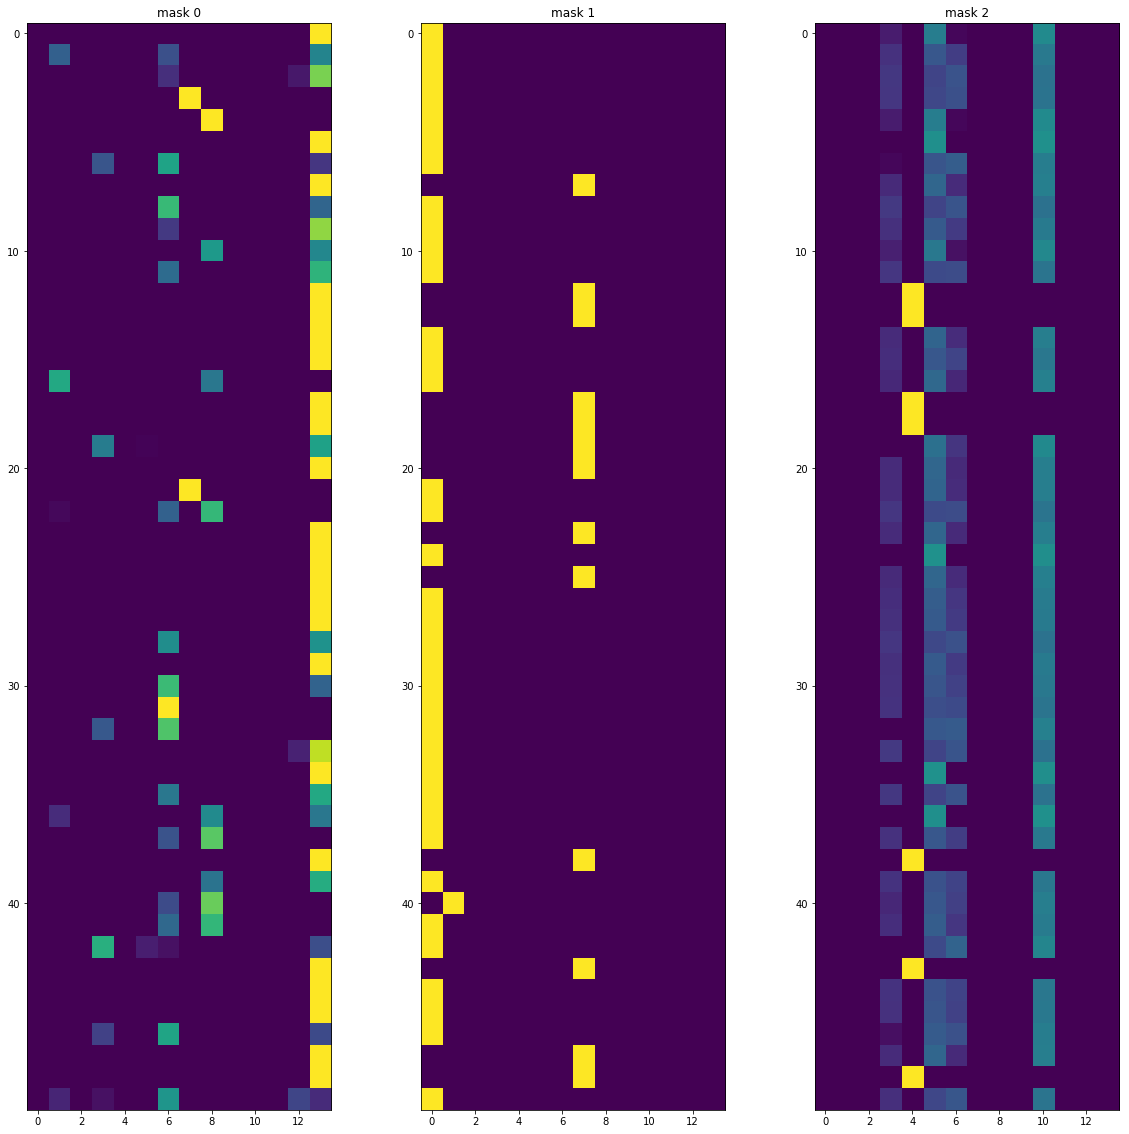

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

### Implementation in XGBoost

In [68]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.470985
Will train until validation_0-rmse hasn't improved in 40 rounds.
[10]	validation_0-rmse:0.339601
[20]	validation_0-rmse:0.314615
[30]	validation_0-rmse:0.309246
[40]	validation_0-rmse:0.308169
[50]	validation_0-rmse:0.307491
[60]	validation_0-rmse:0.307688
[70]	validation_0-rmse:0.307697
[80]	validation_0-rmse:0.307683
[90]	validation_0-rmse:0.308334
Stopping. Best iteration:
[53]	validation_0-rmse:0.307343



XGBRegressor(max_depth=8, n_estimators=1000, n_jobs=-1, subsample=0.7,
             verbosity=0)

In [70]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.09445981424093695
0.09347489128752377


> FastAi wrapper https://pypi.org/project/fast-tabnet/

> Paper https://arxiv.org/pdf/1908.07442.pdf

> Slide https://www.slideshare.net/SebastienFischman/tab-netpresentation/SebastienFischman/tab-netpresentation